# Librerias

In [191]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, PowerTransformer

from plot_metric.functions import BinaryClassification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score


from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Configuracion General

In [2]:
%matplotlib inline
plt.style.use('ggplot')

plt.rcParams["figure.figsize"] = (18,6)
sns.set_palette("husl")

ESTILO = "background-color:lightgrey; display:inline"
pd.options.mode.chained_assignment = None

TARGET = 'readmitted'
SEED = 42

In [3]:
def dropear_columnas(dataset, columnas):
    return dataset.drop(columnas, axis = 1)

In [4]:
df_raw = pd.read_csv("data\diabetic_data.csv")

# Vista del Dataset: Head/Tail

In [5]:
display(df_raw.head())
display(HTML('<br><hr><br>'))
display(df_raw.tail())

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO
101765,443867222,175429310,Caucasian,Male,[70-80),?,1,1,7,6,...,No,No,No,No,No,No,No,No,No,NO


In [6]:
df_raw = dropear_columnas(df_raw, ['encounter_id', 'patient_nbr'])

# Información sobre el Dataset

In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 48 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      101766 non-null  object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  object
 3   weight                    101766 non-null  object
 4   admission_type_id         101766 non-null  int64 
 5   discharge_disposition_id  101766 non-null  int64 
 6   admission_source_id       101766 non-null  int64 
 7   time_in_hospital          101766 non-null  int64 
 8   payer_code                101766 non-null  object
 9   medical_specialty         101766 non-null  object
 10  num_lab_procedures        101766 non-null  int64 
 11  num_procedures            101766 non-null  int64 
 12  num_medications           101766 non-null  int64 
 13  number_outpatient         101766 non-null  int64 
 14  numb

In [8]:
df_raw.drop_duplicates(inplace=True)

# Descripción del Dataset

In [9]:
display(df_raw.describe().T)
display(df_raw.describe(include=[object]))

,count,mean,std,min,25%,50%,75%,max
admission_type_id,101766.0,2.024006,1.445403,1.0,1.0,1.0,3.0,8.0
discharge_disposition_id,101766.0,3.715642,5.280166,1.0,1.0,1.0,4.0,28.0
admission_source_id,101766.0,5.754437,4.064081,1.0,1.0,7.0,7.0,25.0
time_in_hospital,101766.0,4.395987,2.985108,1.0,2.0,4.0,6.0,14.0
num_lab_procedures,101766.0,43.095641,19.674362,1.0,31.0,44.0,57.0,132.0
num_procedures,101766.0,1.339730,1.705807,0.0,0.0,1.0,2.0,6.0
num_medications,101766.0,16.021844,8.127566,1.0,10.0,15.0,20.0,81.0
number_outpatient,101766.0,0.369357,1.267265,0.0,0.0,0.0,0.0,42.0
number_emergency,101766.0,0.197836,0.930472,0.0,0.0,0.0,0.0,76.0
number_inpatient,101766.0,0.635566,1.262863,0.0,0.0,0.0,1.0,21.0


,race,gender,age,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,...,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,6,3,10,10,18,73,717,749,790,4,...,1,4,4,2,2,2,2,2,2,3
top,Caucasian,Female,[70-80),?,?,?,428,276,250,None,...,No,No,No,No,No,No,No,No,Yes,NO
freq,76099,54708,26068,98569,40256,49949,6862,6752,11555,96420,...,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864


# Comprobación de Nulos

In [10]:
df_raw.isnull().sum()

race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose  

# EDA Univariable

In [11]:
columnas_cat      = []
columnas_box_cox  = []
columnas_dropear  = []
columnas_num      = []

## Race

In [12]:
display(df_raw['race'].value_counts(normalize=True))

Caucasian          0.747784
AfricanAmerican    0.188766
?                  0.022336
Hispanic           0.020017
Other              0.014799
Asian              0.006299
Name: race, dtype: float64

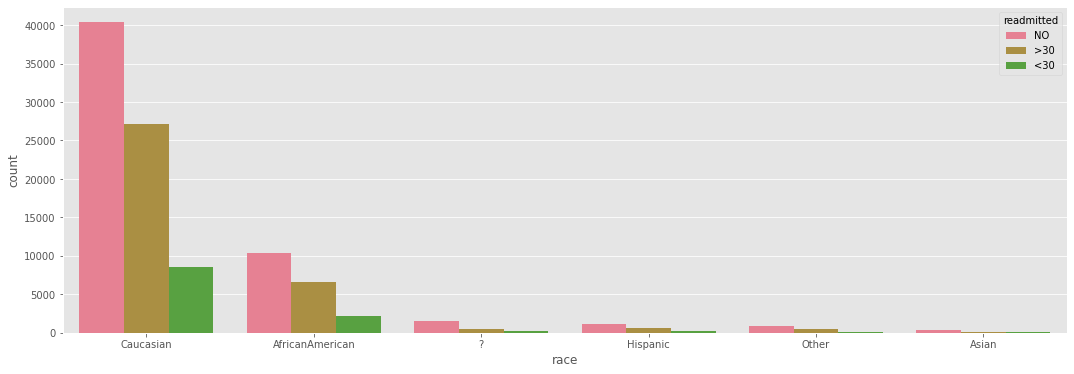

In [13]:
sns.countplot(x=df_raw['race'], 
              order = df_raw['race'].value_counts().index,
              hue=df_raw['readmitted']);

In [14]:
columnas_cat.append('race')
df_raw['race']=df_raw['race'].fillna('UNK')

## Gender

In [15]:
display(df_raw['gender'].value_counts())

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [16]:
columnas_cat.append('gender')

## Age

In [17]:
display(df_raw['age'].value_counts(normalize=True))

[70-80)     0.256156
[60-70)     0.220928
[50-60)     0.169565
[80-90)     0.168986
[40-50)     0.095169
[30-40)     0.037095
[90-100)    0.027445
[20-30)     0.016282
[10-20)     0.006790
[0-10)      0.001582
Name: age, dtype: float64

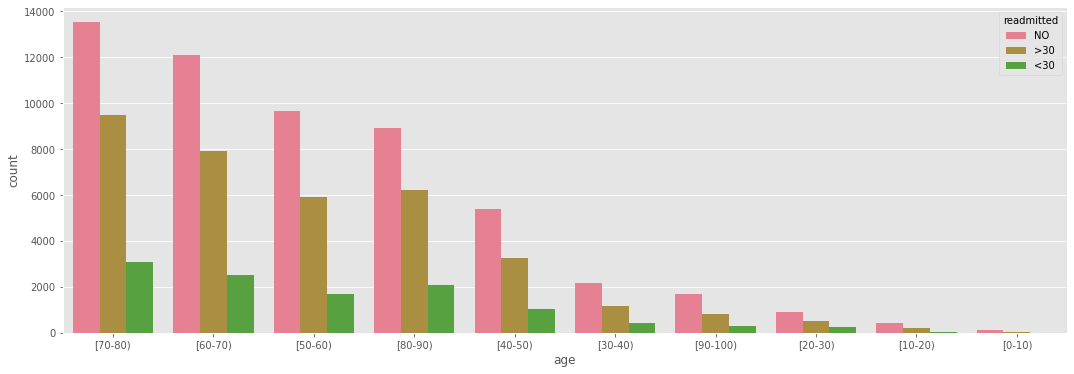

In [18]:
sns.countplot(x=df_raw['age'], 
              order = df_raw['age'].value_counts().index,
              hue=df_raw['readmitted']);

In [19]:
columnas_cat.append('age')

## Weight

In [20]:
display(df_raw['weight'].value_counts(normalize=True))

?            0.968585
[75-100)     0.013128
[50-75)      0.008814
[100-125)    0.006142
[125-150)    0.001425
[25-50)      0.000953
[0-25)       0.000472
[150-175)    0.000344
[175-200)    0.000108
>200         0.000029
Name: weight, dtype: float64

In [21]:
columnas_dropear.append('weight')

In [22]:
df_raw['tiene_weight'] = df_raw['weight'].notnull().astype('int')
columnas_cat.append('tiene_weight')

## Admission type id

In [23]:
display(df_raw['admission_type_id'].value_counts(normalize=True))

1    0.530531
3    0.185416
2    0.181593
6    0.051992
5    0.047020
8    0.003144
7    0.000206
4    0.000098
Name: admission_type_id, dtype: float64

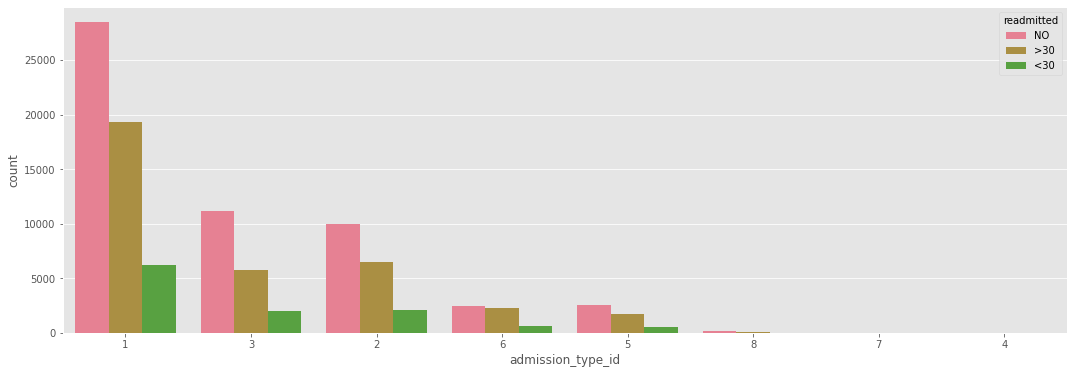

In [24]:
sns.countplot(x=df_raw['admission_type_id'], 
              order = df_raw['admission_type_id'].value_counts().index,
              hue=df_raw['readmitted']);

In [25]:
columnas_cat.append('admission_type_id')

## Discharge disposition id

In [26]:
display(df_raw['discharge_disposition_id'].value_counts())

1     60234
3     13954
6     12902
18     3691
2      2128
22     1993
11     1642
5      1184
25      989
4       815
7       623
23      412
13      399
14      372
28      139
8       108
15       63
24       48
9        21
17       14
16       11
19        8
10        6
27        5
12        3
20        2
Name: discharge_disposition_id, dtype: int64

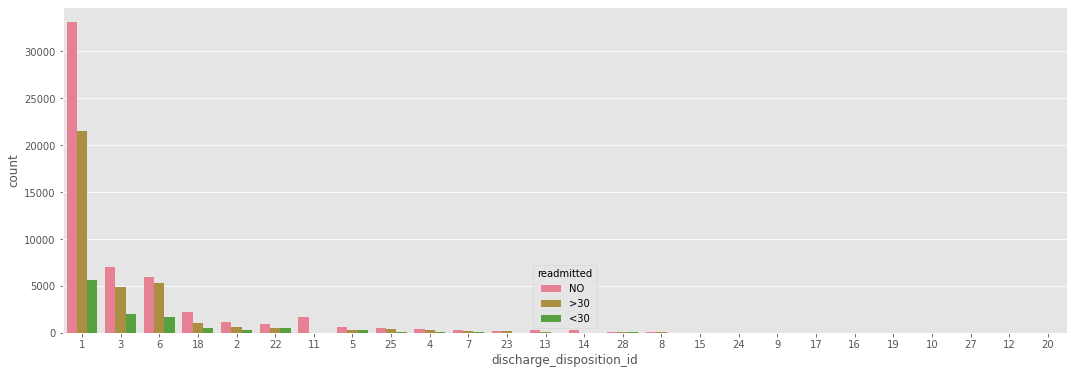

In [27]:
sns.countplot(x=df_raw['discharge_disposition_id'], 
              order = df_raw['discharge_disposition_id'].value_counts().index,
              hue=df_raw['readmitted']);

In [28]:
columnas_cat.append('discharge_disposition_id')

## Admission source id

In [29]:
display(df_raw['admission_source_id'].value_counts(normalize=True))

7     0.564963
1     0.290519
17    0.066633
4     0.031317
6     0.022247
2     0.010848
5     0.008402
3     0.001838
20    0.001582
9     0.001228
8     0.000157
22    0.000118
10    0.000079
11    0.000020
14    0.000020
25    0.000020
13    0.000010
Name: admission_source_id, dtype: float64

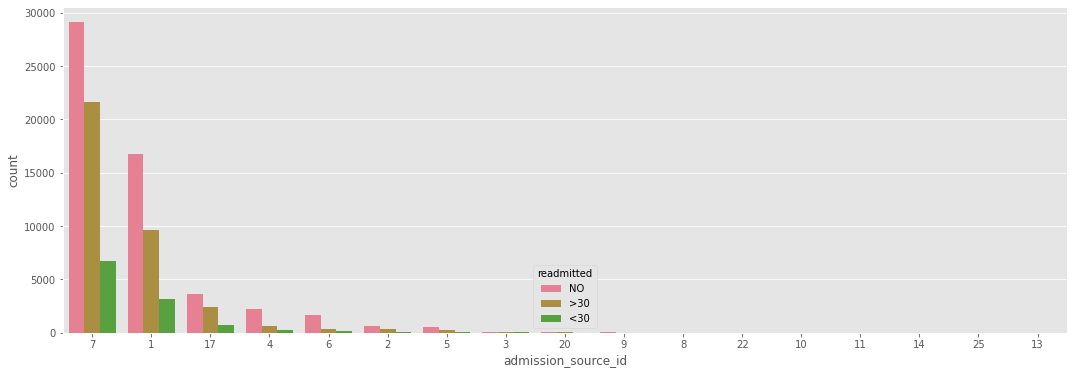

In [30]:
sns.countplot(x=df_raw['admission_source_id'], 
              order = df_raw['admission_source_id'].value_counts().index,
              hue=df_raw['readmitted']);

In [31]:
columnas_cat.append('admission_source_id')

## Time in Hospital

In [32]:
display(df_raw['time_in_hospital'].value_counts(normalize=True))

3     0.174479
2     0.169251
1     0.139614
4     0.136824
5     0.097931
6     0.074082
7     0.057573
8     0.043148
9     0.029499
10    0.023014
11    0.018228
12    0.014229
13    0.011890
14    0.010239
Name: time_in_hospital, dtype: float64

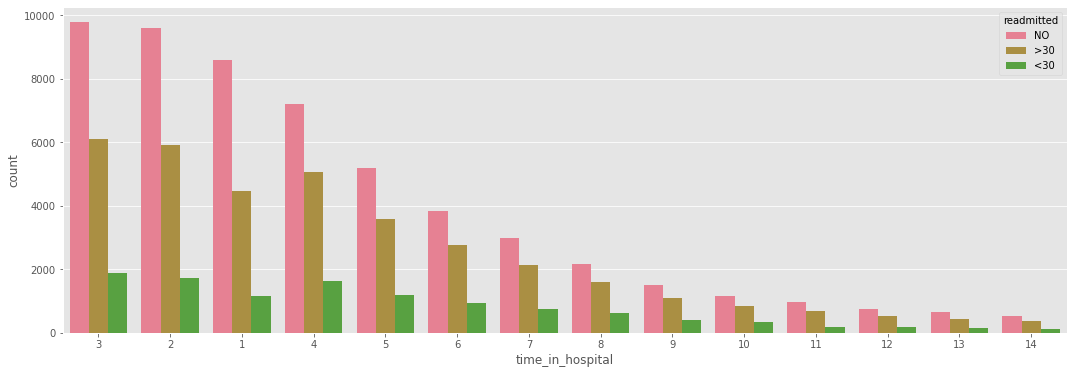

In [33]:
sns.countplot(x=df_raw['time_in_hospital'], 
              order = df_raw['time_in_hospital'].value_counts().index,
              hue=df_raw['readmitted']);

In [34]:
columnas_num.append('time_in_hospital')

## Payer code

In [35]:
display(df_raw['payer_code'].value_counts(normalize=True))

?     0.395574
MC    0.318761
HM    0.061651
SP    0.049201
BC    0.045742
MD    0.034707
CP    0.024890
UN    0.024055
CM    0.019034
OG    0.010151
PO    0.005817
DM    0.005395
CH    0.001435
WC    0.001327
OT    0.000934
MP    0.000776
SI    0.000540
FR    0.000010
Name: payer_code, dtype: float64

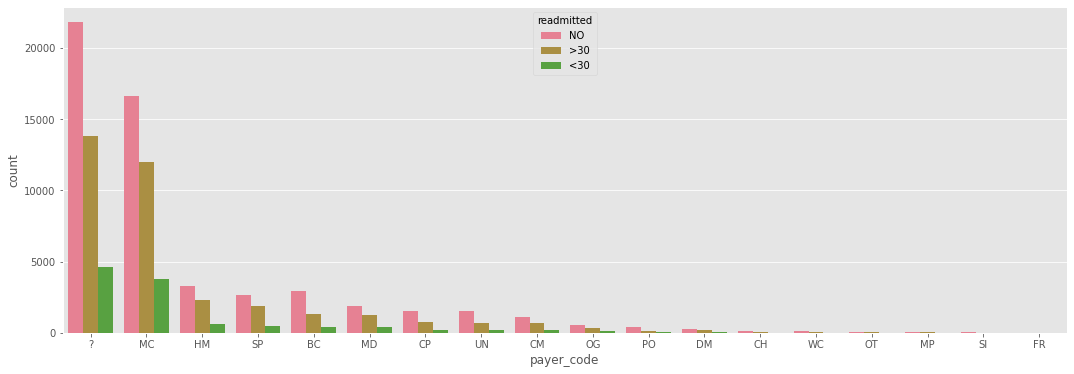

In [36]:
sns.countplot(x=df_raw['payer_code'], 
              order = df_raw['payer_code'].value_counts().index,
              hue=df_raw['readmitted']);

In [37]:
columnas_cat.append('payer_code')

In [38]:
df_raw['payer_code'] = df_raw['payer_code'].fillna('UNK')

## Medical Specialty         

In [39]:
display(df_raw['medical_specialty'].value_counts(normalize=True))

?                                   0.490822
InternalMedicine                    0.143810
Emergency/Trauma                    0.074337
Family/GeneralPractice              0.073109
Cardiology                          0.052591
                                      ...   
Speech                              0.000010
Dermatology                         0.000010
Surgery-PlasticwithinHeadandNeck    0.000010
SportsMedicine                      0.000010
Neurophysiology                     0.000010
Name: medical_specialty, Length: 73, dtype: float64

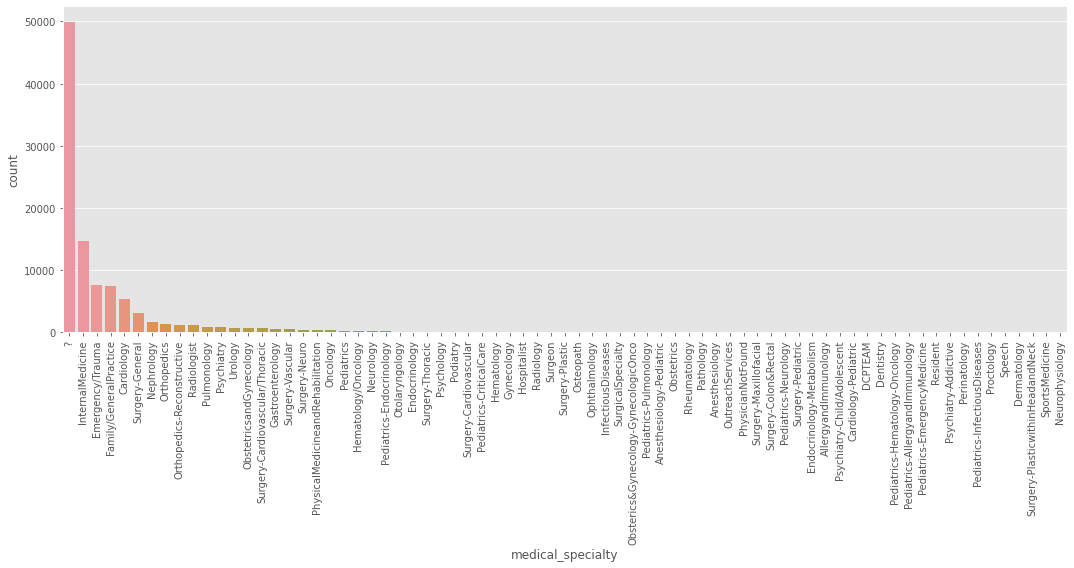

In [40]:
sns.countplot(x=df_raw['medical_specialty'], 
              order = df_raw['medical_specialty'].value_counts().index);
plt.xticks(rotation = 90);

In [41]:
columnas_cat.append('medical_specialty')

In [42]:
df_raw['medical_specialty']=df_raw['medical_specialty'].fillna('UNK')

In [43]:
top_10=['UNK','InternalMedicine',
        'Emergency/Trauma','Family/GeneralPractice','Cardiology','Surgery-General',
        'Nephrology','Orthopedics','Orthopedics-Reconstructive','Radiologist']

df_raw.loc[~df_raw['medical_specialty'].isin(top_10), 'medical_specialty'] = 'Other'

## N° Lab Procedures 

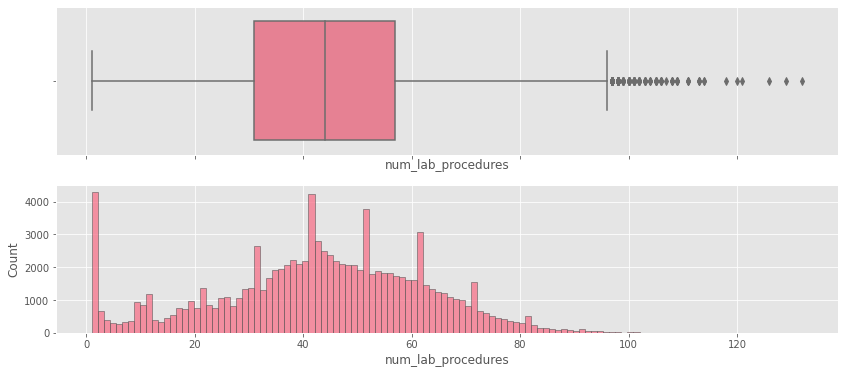

In [44]:
fig, axs = plt.subplots(2, figsize = (14,6), sharex = True)

sns.boxplot(x=df_raw['num_lab_procedures'], ax=axs[0]);
sns.histplot(
    df_raw,
    x="num_lab_procedures",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
    ax=axs[1]
);

## N° Procedures

In [45]:
display(df_raw['num_procedures'].value_counts(normalize=True))

0    0.458424
1    0.203821
2    0.124963
3    0.092791
6    0.048680
4    0.041075
5    0.030246
Name: num_procedures, dtype: float64

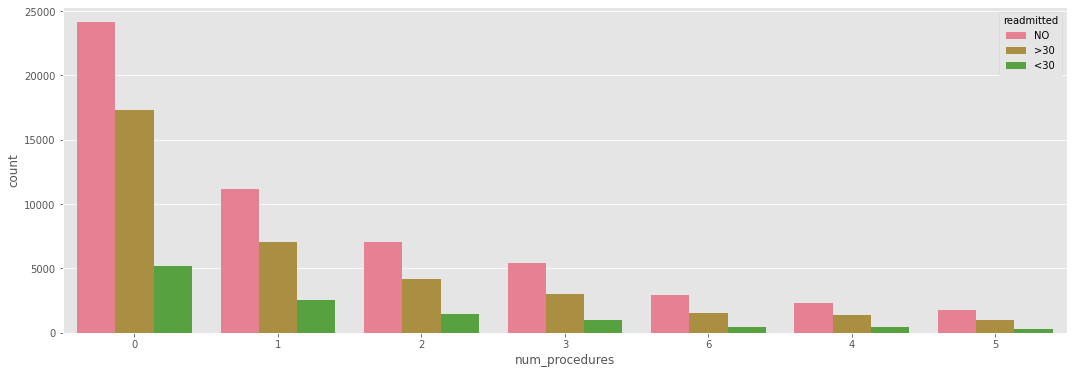

In [46]:
sns.countplot(x=df_raw['num_procedures'], 
              order = df_raw['num_procedures'].value_counts().index,
              hue=df_raw['readmitted']);

In [47]:
columnas_cat.append('num_procedures')

## N° Medications 

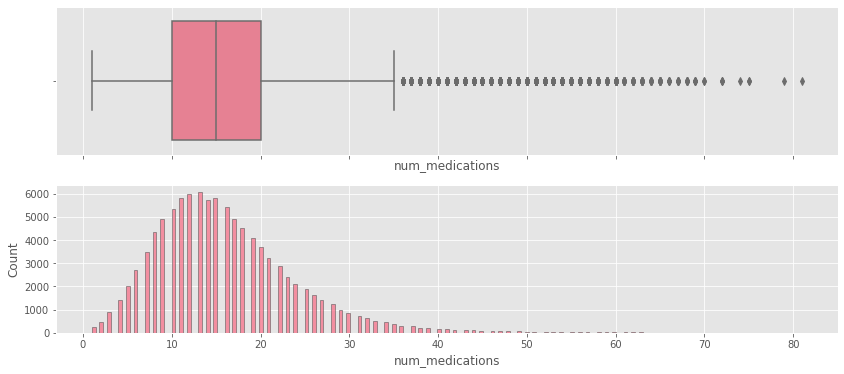

In [48]:
fig, axs = plt.subplots(2, figsize = (14,6), sharex = True)

sns.boxplot(x=df_raw['num_medications'], ax=axs[0]);
sns.histplot(
    df_raw,
    x="num_medications",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
    ax=axs[1]
);

In [49]:
columnas_num.append("num_medications")

## N° Outpatient

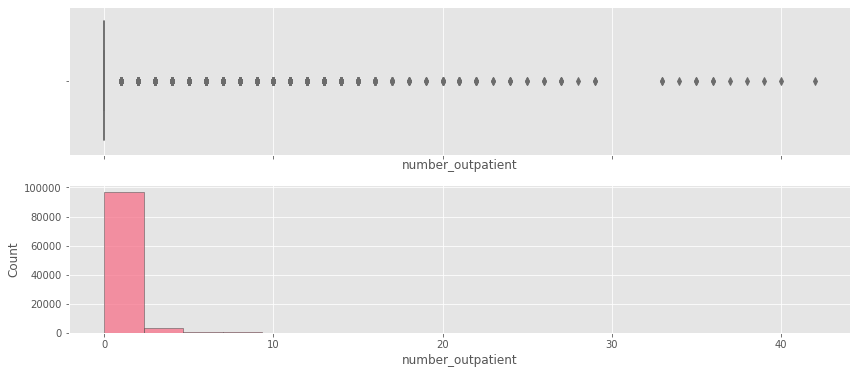

In [50]:
fig, axs = plt.subplots(2, figsize = (14,6), sharex = True)

sns.boxplot(x=df_raw['number_outpatient'], ax=axs[0]);
sns.histplot(
    df_raw,
    x="number_outpatient",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
    ax=axs[1]
);

In [51]:
columnas_num.append("number_outpatient")
columnas_box_cox.append("number_outpatient")

## N° emergency

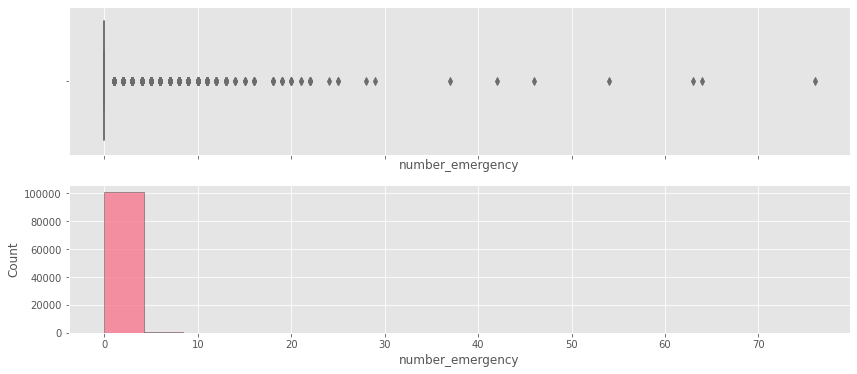

In [52]:
fig, axs = plt.subplots(2, figsize = (14,6), sharex = True)

sns.boxplot(x=df_raw['number_emergency'], ax=axs[0]);
sns.histplot(
    df_raw,
    x="number_emergency",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
    ax=axs[1]
);

In [53]:
columnas_num.append("number_emergency")
columnas_box_cox.append("number_emergency")

## N° inpatient

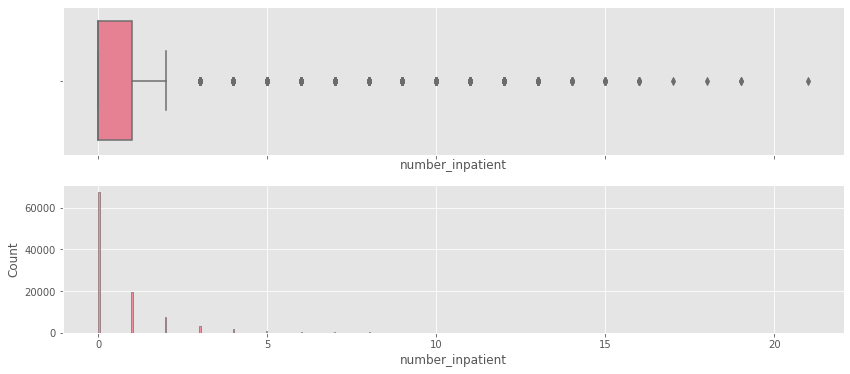

In [54]:
fig, axs = plt.subplots(2, figsize = (14,6), sharex = True)

sns.boxplot(x=df_raw['number_inpatient'], ax=axs[0]);
sns.histplot(
    df_raw,
    x="number_inpatient",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
    ax=axs[1]
);

In [55]:
columnas_num.append('number_inpatient')

## Diagnostic 1

In [56]:
display(df_raw['diag_1'].value_counts(normalize=True))

428    0.067429
414    0.064668
786    0.039463
410    0.035513
486    0.034471
         ...   
363    0.000010
974    0.000010
988    0.000010
477    0.000010
10     0.000010
Name: diag_1, Length: 717, dtype: float64

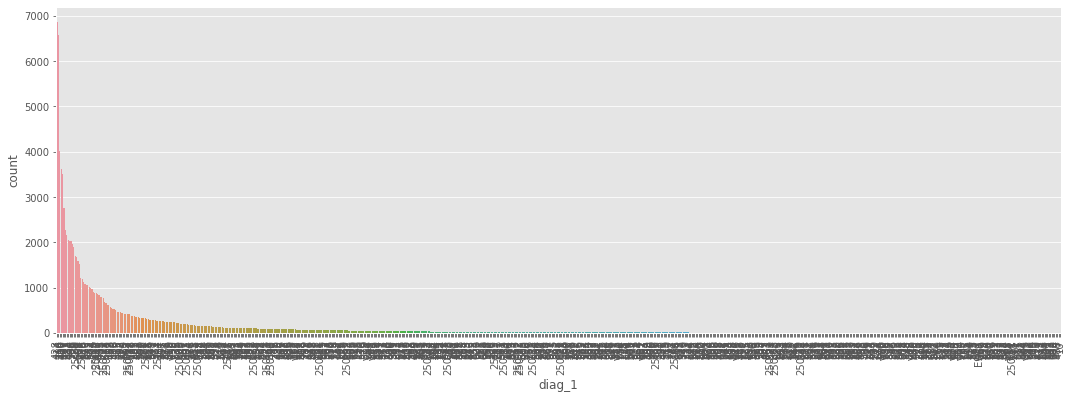

In [57]:
sns.countplot(x=df_raw['diag_1'], 
              order = df_raw['diag_1'].value_counts().index);
plt.xticks(rotation = 90);

In [58]:
columnas_dropear.append('diag_1')

## Diagnostic 2

In [59]:
display(df_raw['diag_2'].value_counts(normalize=True))

276     0.066348
428     0.065464
250     0.059656
427     0.049486
401     0.036712
          ...   
927     0.000010
271     0.000010
E938    0.000010
130     0.000010
811     0.000010
Name: diag_2, Length: 749, dtype: float64

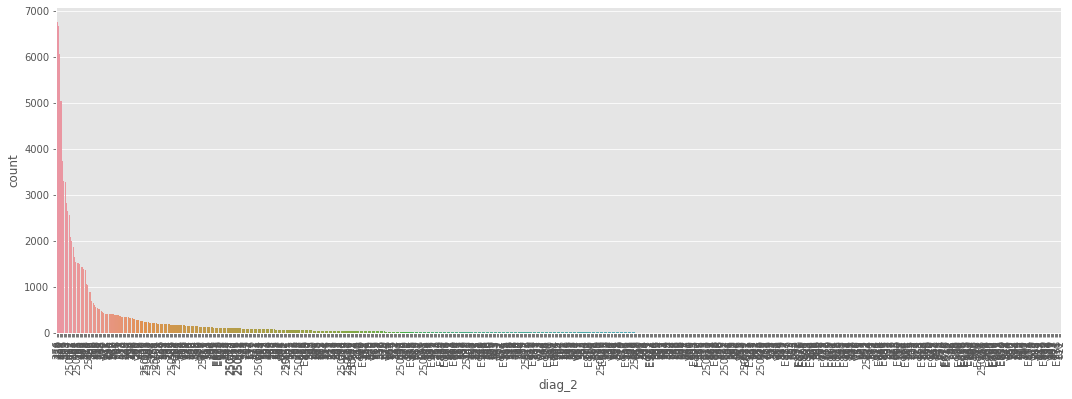

In [60]:
sns.countplot(x=df_raw['diag_2'], 
              order = df_raw['diag_2'].value_counts().index);
plt.xticks(rotation = 90);

In [61]:
columnas_dropear.append('diag_2')

## Diagnostic 3

In [62]:
display(df_raw['diag_3'].value_counts(normalize=True))

250     0.113545
401     0.081452
276     0.050852
428     0.044976
427     0.038864
          ...   
57      0.000010
148     0.000010
E949    0.000010
987     0.000010
361     0.000010
Name: diag_3, Length: 790, dtype: float64

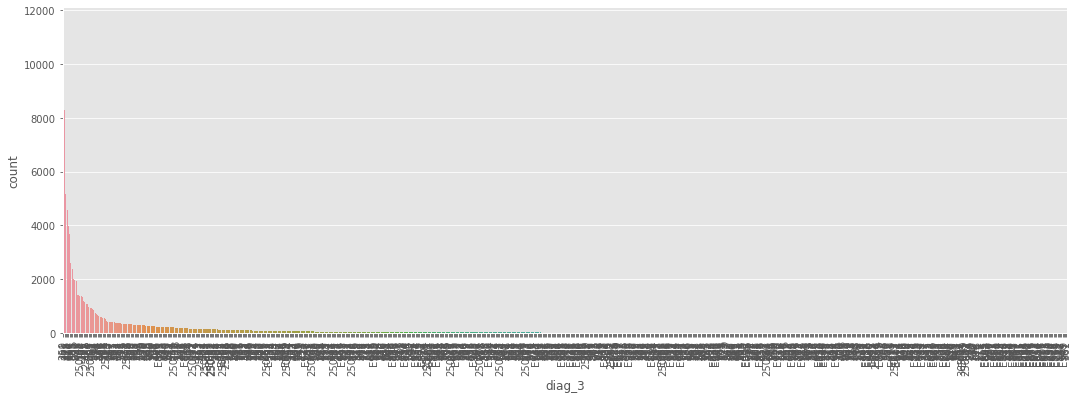

In [63]:
sns.countplot(x=df_raw['diag_3'], 
              order = df_raw['diag_3'].value_counts().index);
plt.xticks(rotation = 90);

In [64]:
columnas_dropear.append('diag_3')

## N° diagnoses

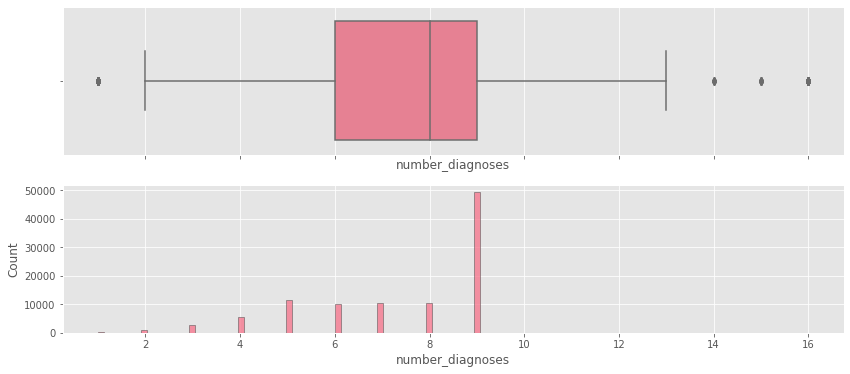

In [65]:
fig, axs = plt.subplots(2, figsize = (14,6), sharex = True)

sns.boxplot(x=df_raw['number_diagnoses'], ax=axs[0]);
sns.histplot(
    df_raw,
    x="number_diagnoses",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
    ax=axs[1],
);

In [66]:
columnas_num.append('number_diagnoses')

## max glu serum 

In [67]:
display(df_raw['max_glu_serum'].value_counts(normalize=True))

None    0.947468
Norm    0.025519
>200    0.014592
>300    0.012421
Name: max_glu_serum, dtype: float64

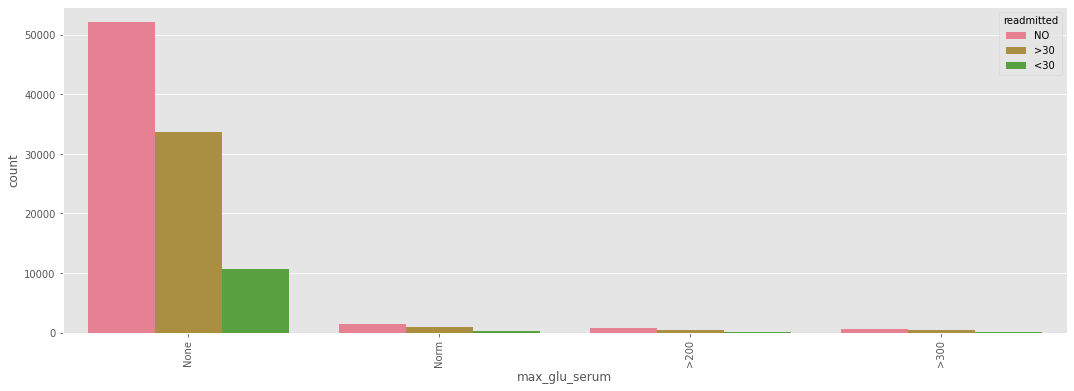

In [68]:
sns.countplot(x = 'max_glu_serum', 
              order = df_raw['max_glu_serum'].value_counts().index,
              data = df_raw,
              hue='readmitted')

plt.xticks(rotation = 90);

In [69]:
columnas_dropear.append('max_glu_serum')

## A1 Cresult

In [70]:
display(df_raw['A1Cresult'].value_counts(normalize=True))

None    0.832773
>8      0.080734
Norm    0.049034
>7      0.037458
Name: A1Cresult, dtype: float64

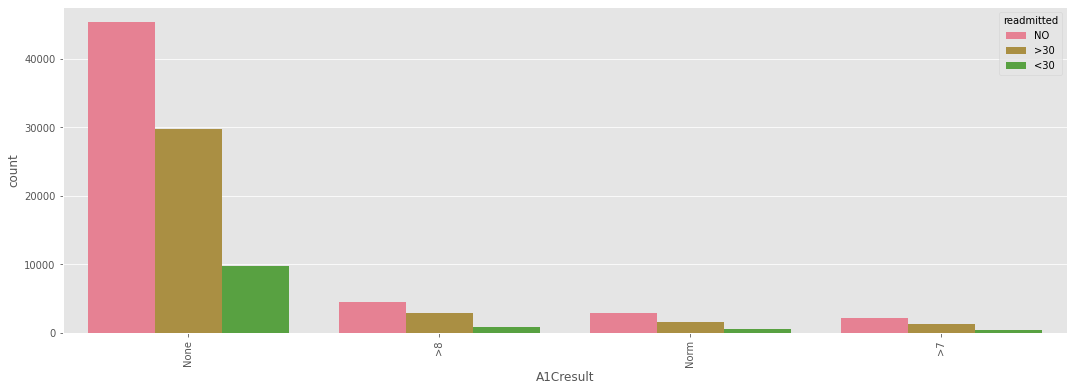

In [71]:
sns.countplot(x = 'A1Cresult', 
              order = df_raw['A1Cresult'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [72]:
columnas_dropear.append('A1Cresult')

## Metformin

In [73]:
display(df_raw['metformin'].value_counts(normalize=True))

No        0.803589
Steady    0.180276
Up        0.010485
Down      0.005650
Name: metformin, dtype: float64

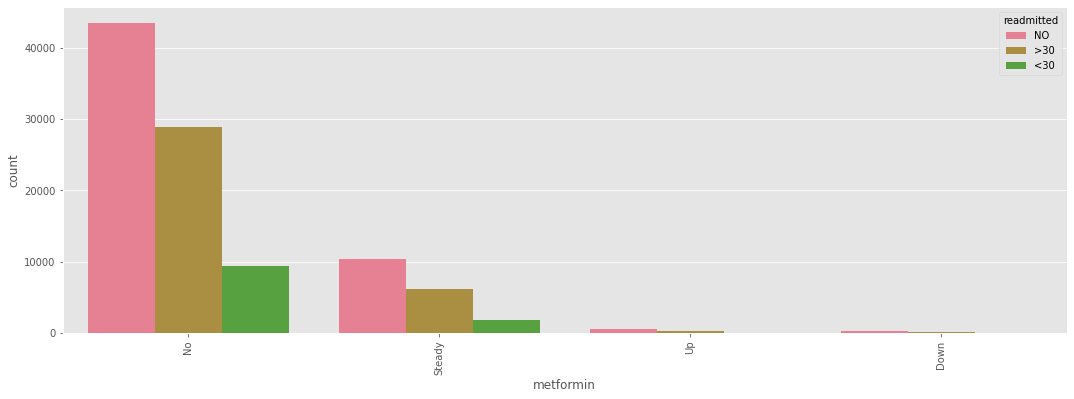

In [74]:
sns.countplot(x = 'metformin', 
              order = df_raw['metformin'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [75]:
columnas_dropear.append('metformin')

## Repaglinide

In [76]:
display(df_raw['repaglinide'].value_counts(normalize=True))

No        0.984877
Steady    0.013600
Up        0.001081
Down      0.000442
Name: repaglinide, dtype: float64

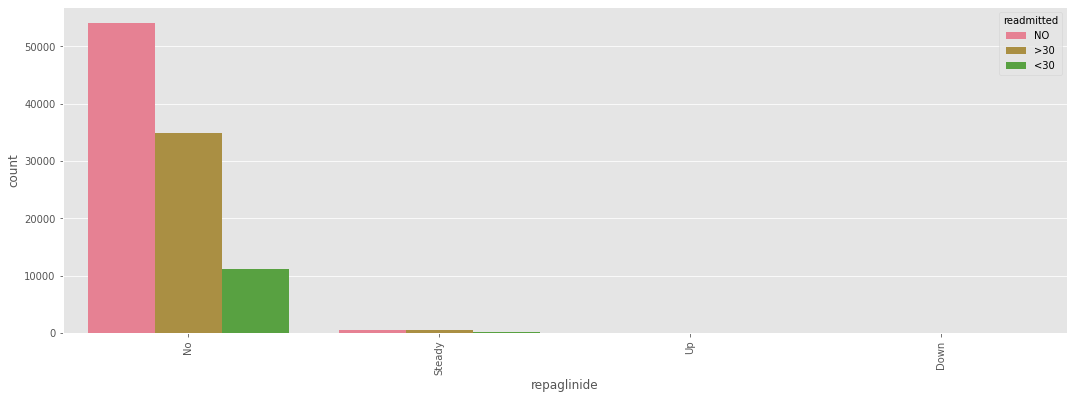

In [77]:
sns.countplot(x = 'repaglinide', 
              order = df_raw['repaglinide'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [78]:
columnas_dropear.append('repaglinide')

## Nateglinide

In [79]:
display(df_raw['nateglinide'].value_counts(normalize=True))

No        0.993092
Steady    0.006564
Up        0.000236
Down      0.000108
Name: nateglinide, dtype: float64

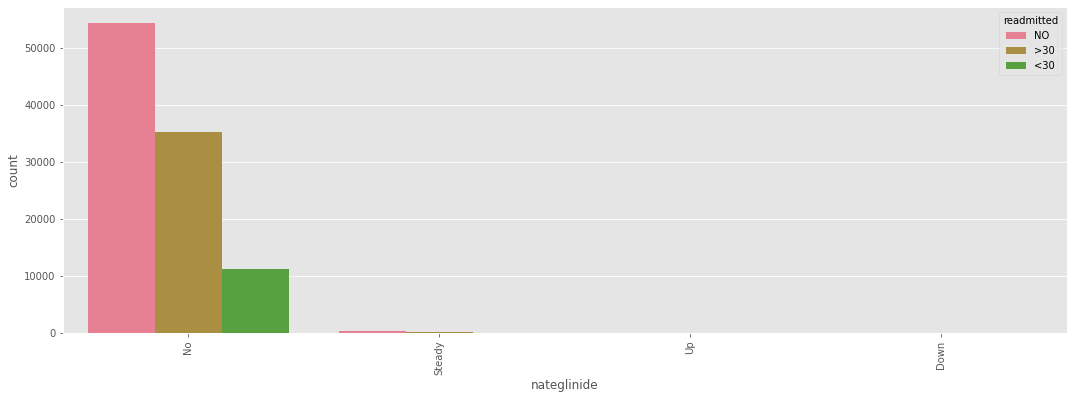

In [80]:
sns.countplot(x = 'nateglinide', 
              order = df_raw['nateglinide'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [81]:
columnas_dropear.append('nateglinide')

## Chlorpropamide

In [82]:
display(df_raw['chlorpropamide'].value_counts(normalize=True))

No        0.999155
Steady    0.000776
Up        0.000059
Down      0.000010
Name: chlorpropamide, dtype: float64

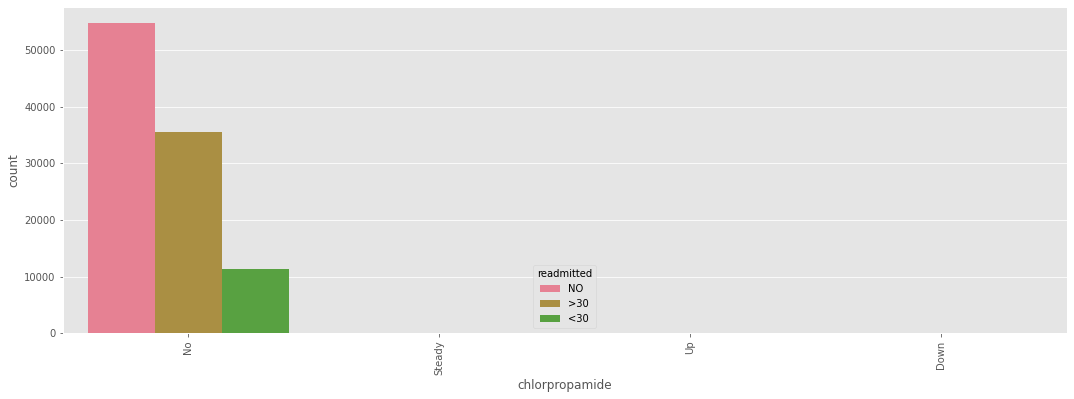

In [83]:
sns.countplot(x = 'chlorpropamide', 
              order = df_raw['chlorpropamide'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [84]:
columnas_dropear.append('chlorpropamide')

## Glimepiride

In [85]:
display(df_raw['glimepiride'].value_counts(normalize=True))

No        0.948991
Steady    0.045890
Up        0.003213
Down      0.001906
Name: glimepiride, dtype: float64

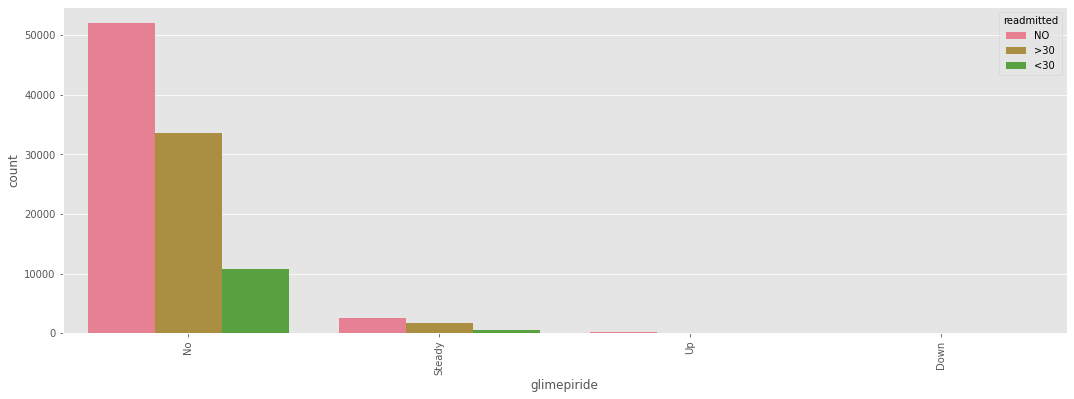

In [86]:
sns.countplot(x = 'glimepiride', 
              order = df_raw['glimepiride'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [87]:
columnas_dropear.append('glimepiride')

## Acetohexamide

In [88]:
display(df_raw['acetohexamide'].value_counts(normalize=True))

No        0.99999
Steady    0.00001
Name: acetohexamide, dtype: float64

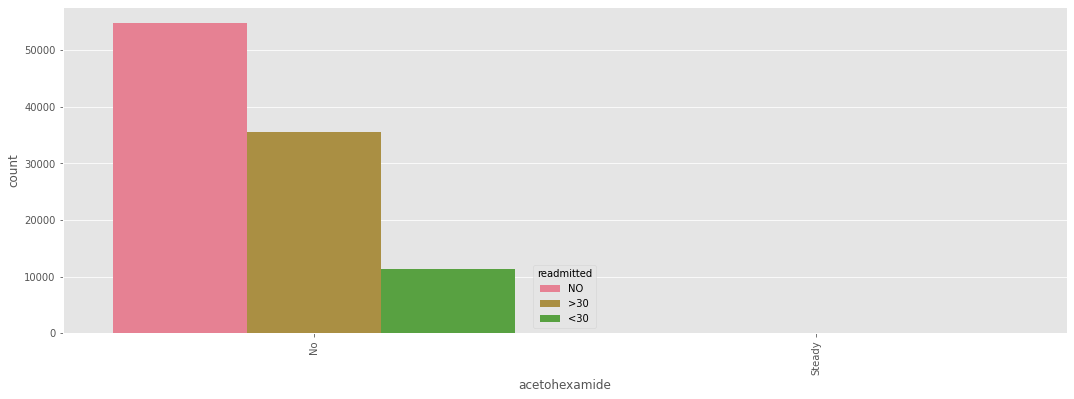

In [89]:
sns.countplot(x = 'acetohexamide', 
              order = df_raw['acetohexamide'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [90]:
columnas_dropear.append('acetohexamide')

## Glyburide

In [91]:
display(df_raw['glyburide'].value_counts(normalize=True))

No        0.895348
Steady    0.091131
Up        0.007979
Down      0.005542
Name: glyburide, dtype: float64

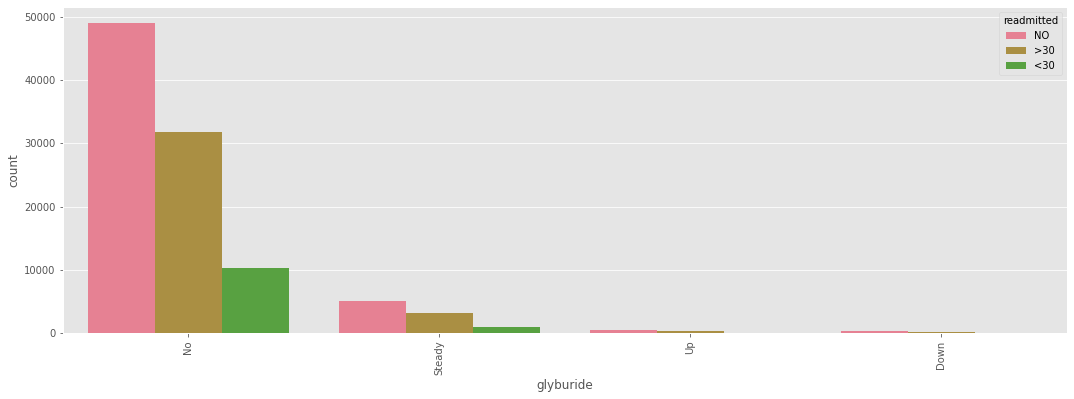

In [92]:
sns.countplot(x = 'glyburide', 
              order = df_raw['glyburide'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [93]:
columnas_dropear.append('glyburide')

## Tolbutamide 

In [94]:
display(df_raw['tolbutamide'].value_counts(normalize=True))

No        0.999774
Steady    0.000226
Name: tolbutamide, dtype: float64

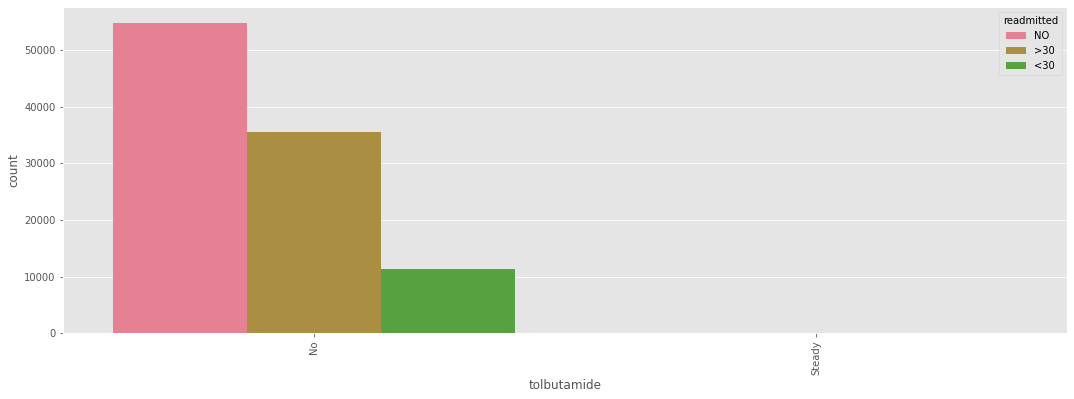

In [95]:
sns.countplot(x = 'tolbutamide', 
              order = df_raw['tolbutamide'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [96]:
columnas_dropear.append('tolbutamide')

## Pioglitazone

In [97]:
display(df_raw['pioglitazone'].value_counts(normalize=True))

No        0.927992
Steady    0.068549
Up        0.002299
Down      0.001160
Name: pioglitazone, dtype: float64

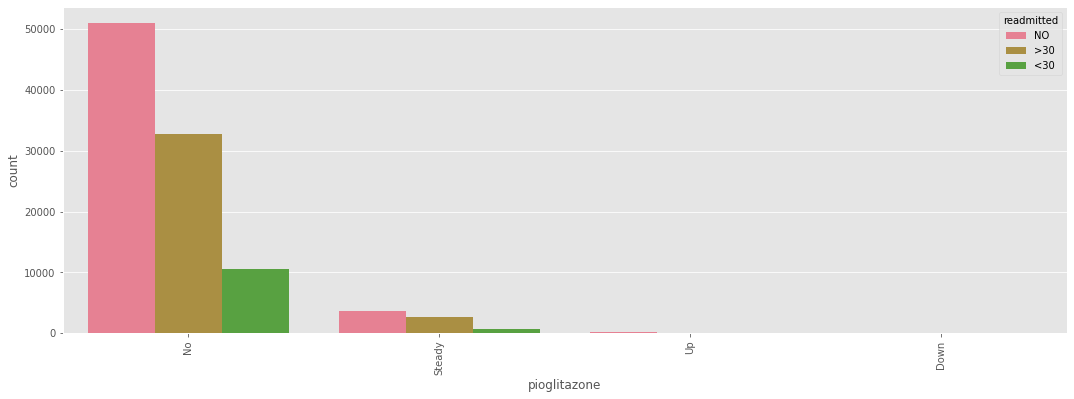

In [98]:
sns.countplot(x = 'pioglitazone', 
              order = df_raw['pioglitazone'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [99]:
columnas_dropear.append('pioglitazone')

## Rosiglitazone

In [100]:
display(df_raw['rosiglitazone'].value_counts(normalize=True))

No        0.937455
Steady    0.059941
Up        0.001749
Down      0.000855
Name: rosiglitazone, dtype: float64

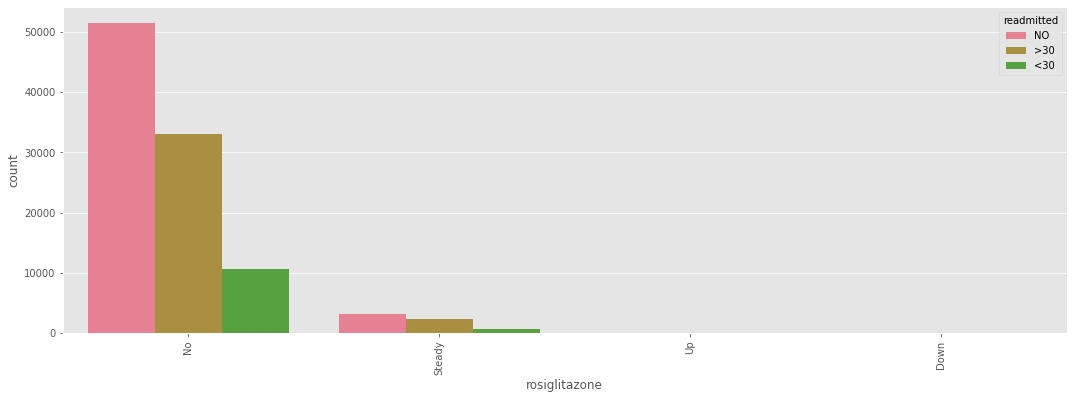

In [101]:
sns.countplot(x = 'rosiglitazone', 
              order = df_raw['rosiglitazone'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [102]:
columnas_dropear.append('rosiglitazone')

## Acarbose

In [103]:
display(df_raw['acarbose'].value_counts(normalize=True))

No        0.996973
Steady    0.002899
Up        0.000098
Down      0.000029
Name: acarbose, dtype: float64

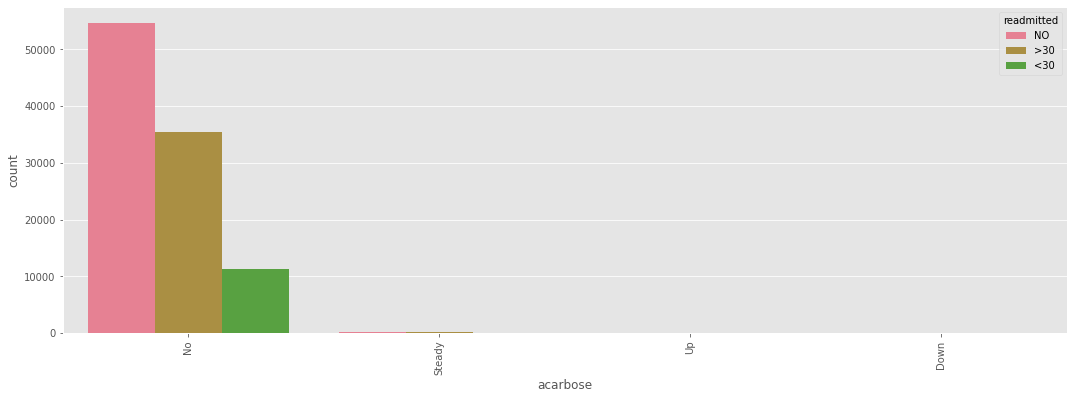

In [104]:
sns.countplot(x = 'acarbose', 
              order = df_raw['acarbose'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [105]:
columnas_dropear.append('acarbose')

## Miglitol

In [106]:
display(df_raw['miglitol'].value_counts(normalize=True))

No        0.999627
Steady    0.000305
Down      0.000049
Up        0.000020
Name: miglitol, dtype: float64

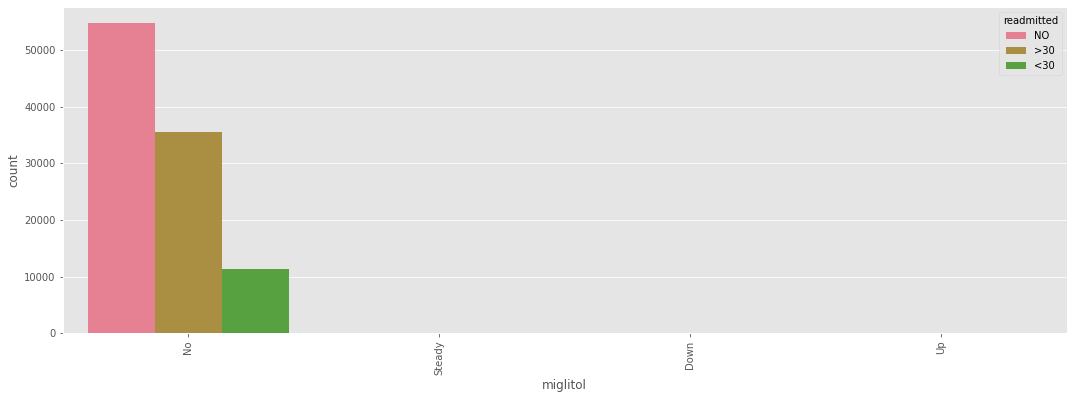

In [107]:
sns.countplot(x = 'miglitol', 
              order = df_raw['miglitol'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [108]:
columnas_dropear.append('miglitol')

## Troglitazone

In [109]:
display(df_raw['troglitazone'].value_counts(normalize=True))

No        0.999971
Steady    0.000029
Name: troglitazone, dtype: float64

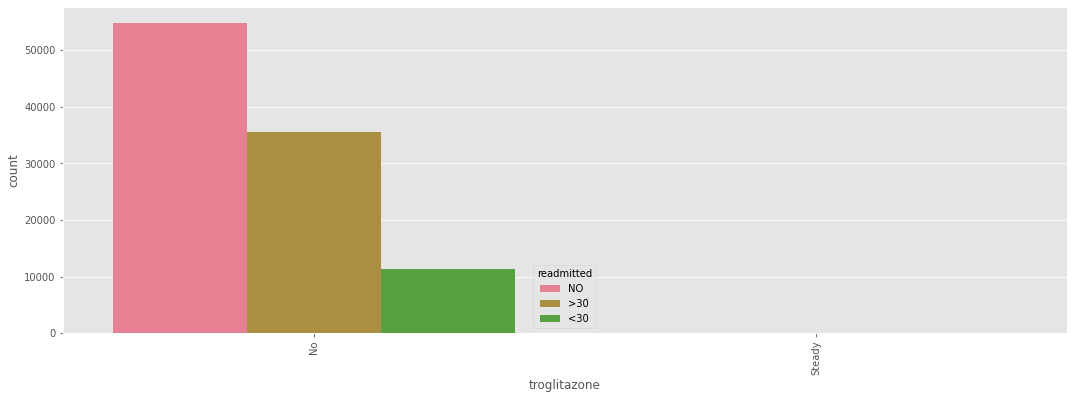

In [110]:
sns.countplot(x = 'troglitazone', 
              order = df_raw['troglitazone'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [111]:
columnas_dropear.append('troglitazone')

## Tolazamide

In [112]:
display(df_raw['tolazamide'].value_counts(normalize=True))

No        0.999617
Steady    0.000373
Up        0.000010
Name: tolazamide, dtype: float64

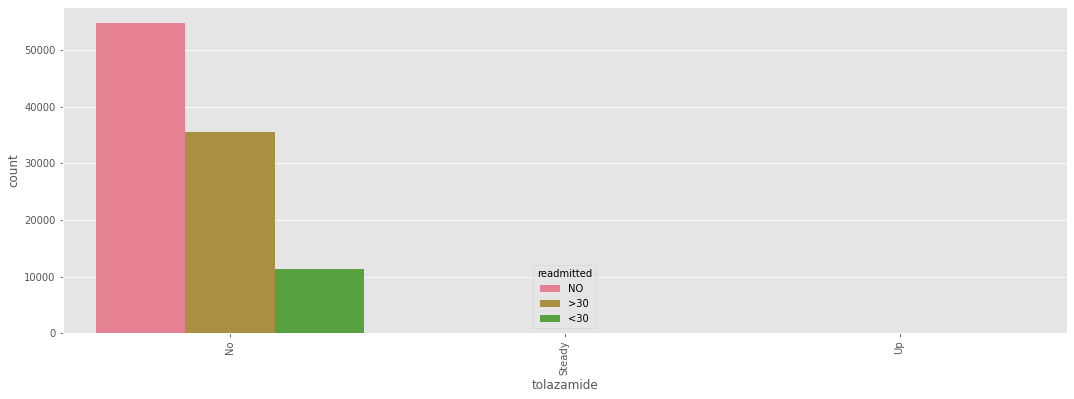

In [113]:
sns.countplot(x = 'tolazamide', 
              order = df_raw['tolazamide'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [114]:
columnas_dropear.append('tolazamide')

## Examide

In [115]:
display(df_raw['examide'].value_counts(normalize=True))

No    1.0
Name: examide, dtype: float64

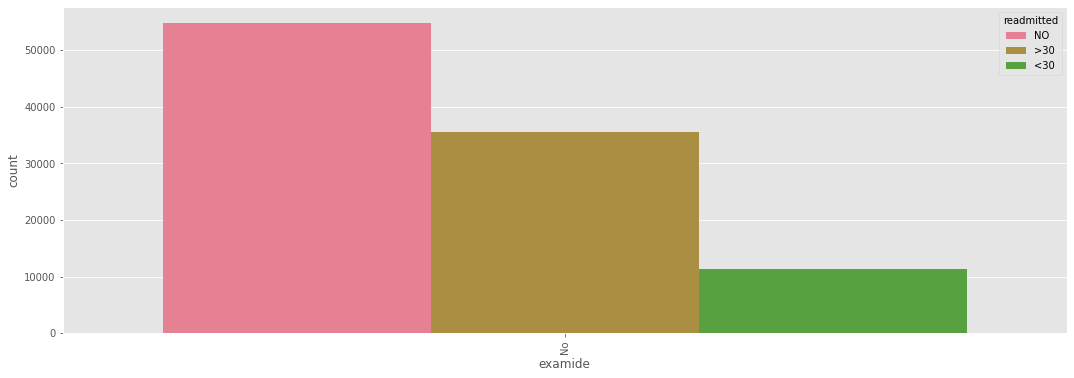

In [116]:
sns.countplot(x = 'examide', 
              order = df_raw['examide'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [117]:
columnas_dropear.append('examide')

## Citoglipton

In [118]:
display(df_raw['citoglipton'].value_counts(normalize=True))

No    1.0
Name: citoglipton, dtype: float64

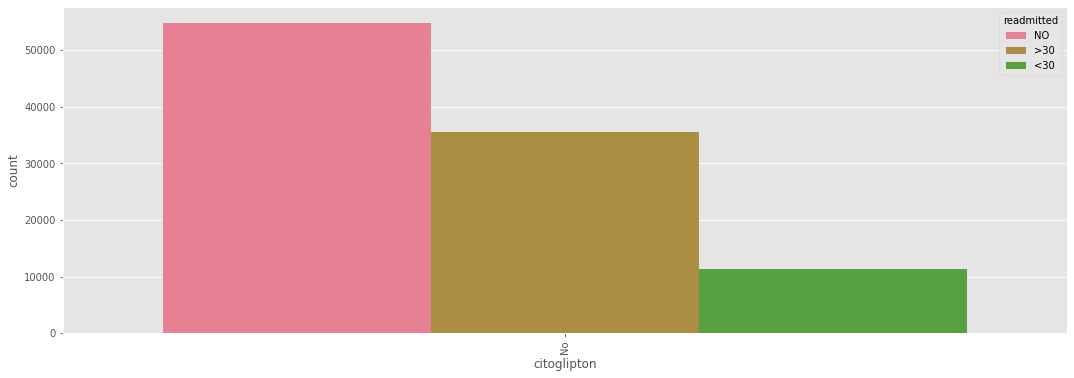

In [119]:
sns.countplot(x = 'citoglipton', 
              order = df_raw['citoglipton'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [120]:
columnas_dropear.append('citoglipton')

## Insulin

In [121]:
display(df_raw['insulin'].value_counts(normalize=True))

No        0.465607
Steady    0.303137
Down      0.120060
Up        0.111196
Name: insulin, dtype: float64

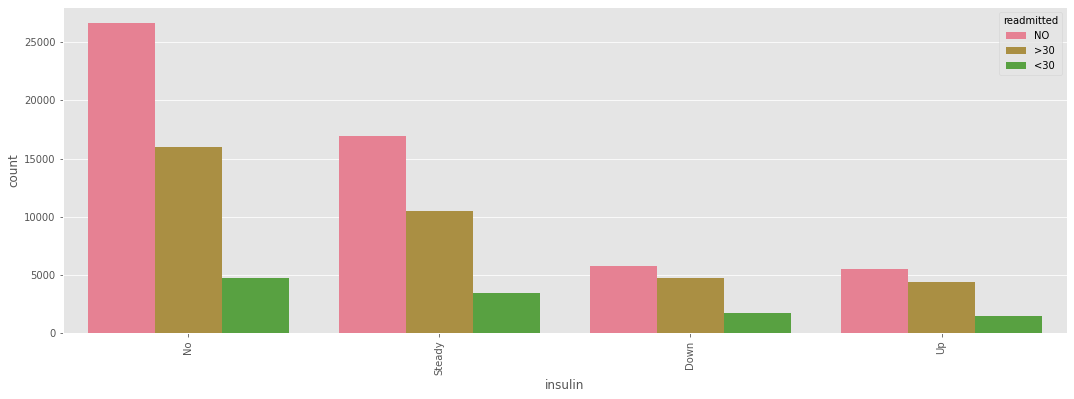

In [122]:
sns.countplot(x = 'insulin', 
              order = df_raw['insulin'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [123]:
columnas_cat.append('insulin')

## Glyburide-metformin

In [124]:
display(df_raw['glyburide-metformin'].value_counts(normalize=True))

No        0.993063
Steady    0.006800
Up        0.000079
Down      0.000059
Name: glyburide-metformin, dtype: float64

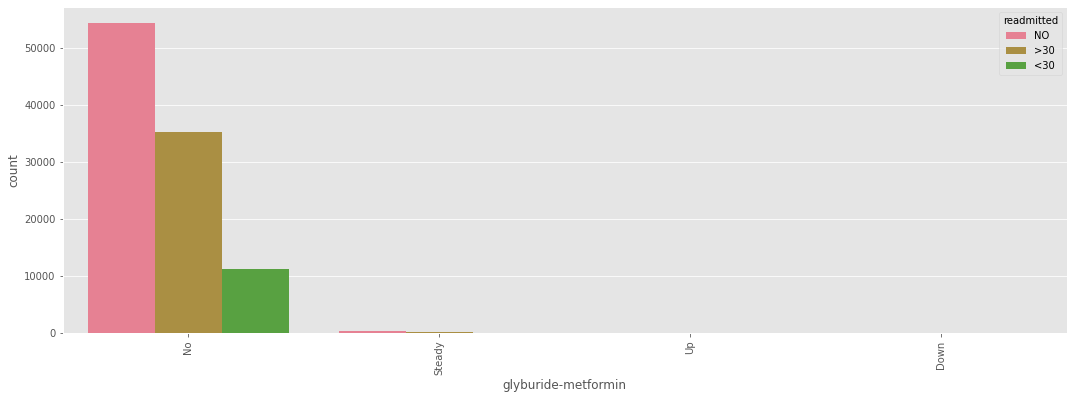

In [125]:
sns.countplot(x = 'glyburide-metformin', 
              order = df_raw['glyburide-metformin'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [126]:
columnas_dropear.append('glyburide-metformin')

## Glipizide-metformin

In [127]:
display(df_raw['glipizide-metformin'].value_counts(normalize=True))

No        0.999872
Steady    0.000128
Name: glipizide-metformin, dtype: float64

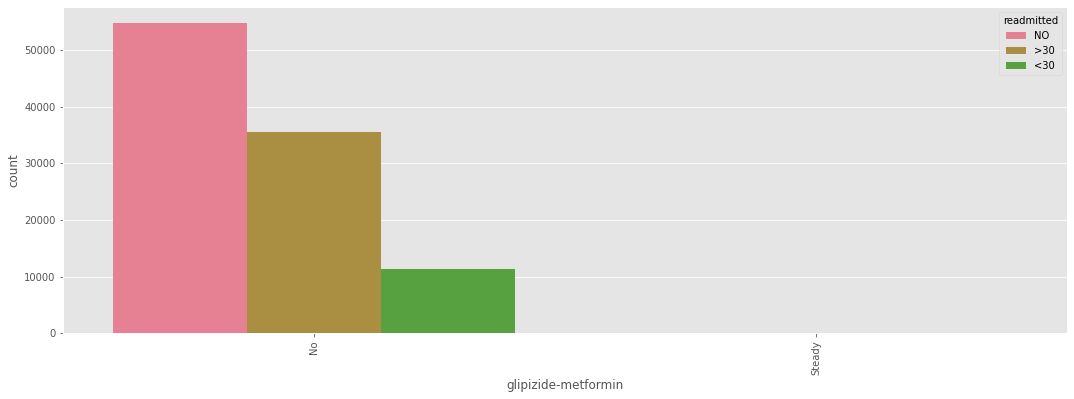

In [128]:
sns.countplot(x = 'glipizide-metformin', 
              order = df_raw['glipizide-metformin'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [129]:
columnas_dropear.append('glipizide-metformin')

## Glimepiride-pioglitazone

In [130]:
display(df_raw['glimepiride-pioglitazone'].value_counts(normalize=True))

No        0.99999
Steady    0.00001
Name: glimepiride-pioglitazone, dtype: float64

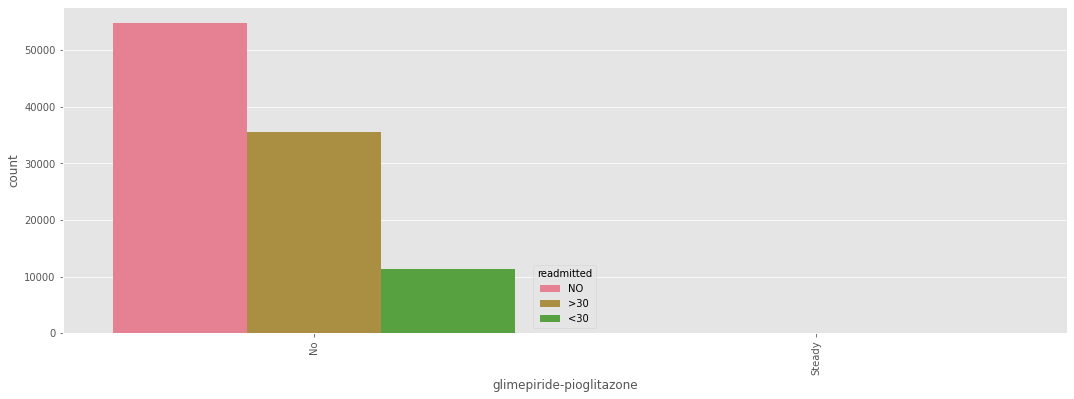

In [131]:
sns.countplot(x = 'glimepiride-pioglitazone', 
              order = df_raw['glimepiride-pioglitazone'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [132]:
columnas_dropear.append('glimepiride-pioglitazone')

## Metformin-rosiglitazone

In [133]:
display(df_raw['metformin-rosiglitazone'].value_counts(normalize=True))

No        0.99998
Steady    0.00002
Name: metformin-rosiglitazone, dtype: float64

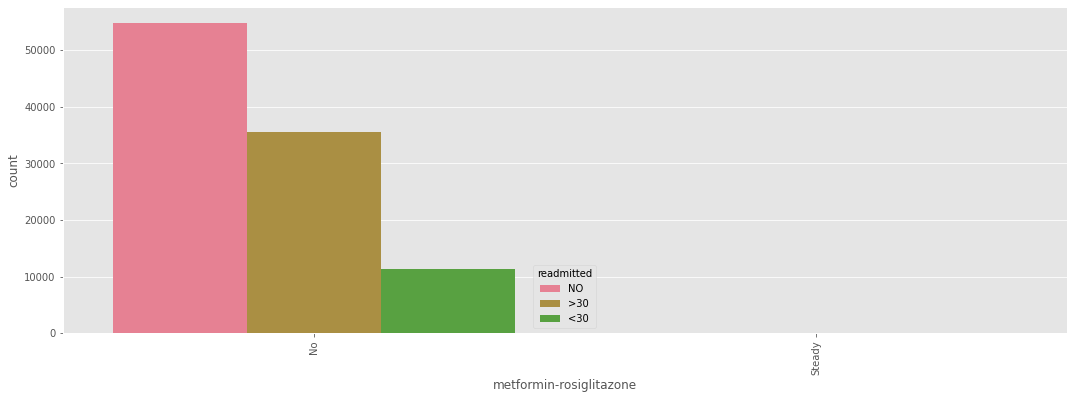

In [134]:
sns.countplot(x = 'metformin-rosiglitazone', 
              order = df_raw['metformin-rosiglitazone'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [135]:
columnas_dropear.append('metformin-rosiglitazone')

## Metformin-pioglitazone

In [136]:
display(df_raw['metformin-pioglitazone'].value_counts(normalize=True))

No        0.99999
Steady    0.00001
Name: metformin-pioglitazone, dtype: float64

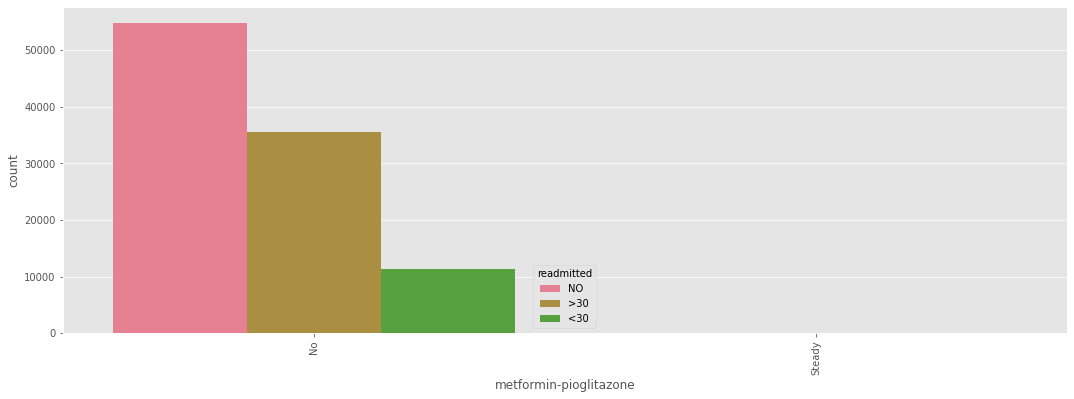

In [137]:
sns.countplot(x = 'metformin-pioglitazone', 
              order = df_raw['metformin-pioglitazone'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [138]:
columnas_dropear.append('metformin-pioglitazone')

## Change

In [139]:
display(df_raw['change'].value_counts(normalize=True))

No    0.538048
Ch    0.461952
Name: change, dtype: float64

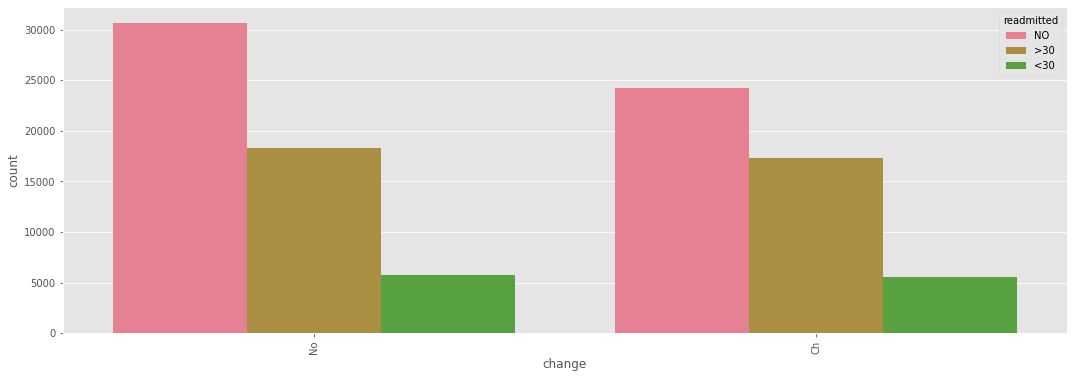

In [140]:
sns.countplot(x = 'change', 
              order = df_raw['change'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [141]:
columnas_cat.append('change')

## DiabetesMed 

In [142]:
display(df_raw['diabetesMed'].value_counts(normalize=True))

Yes    0.770031
No     0.229969
Name: diabetesMed, dtype: float64

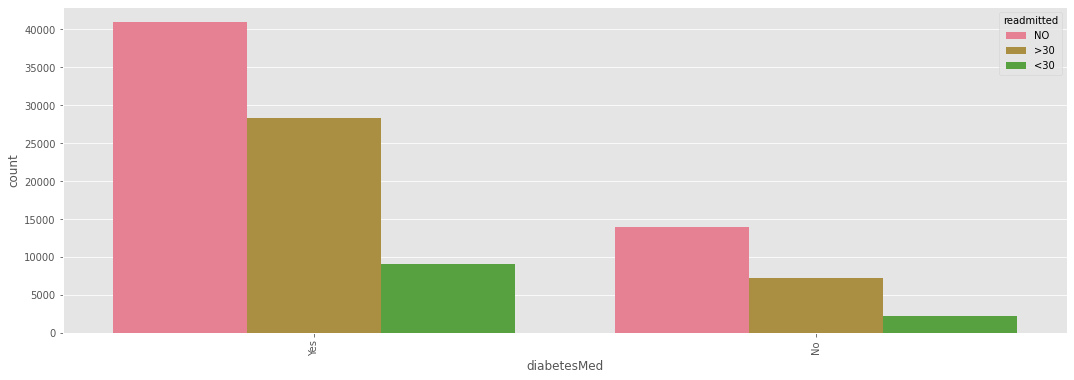

In [143]:
sns.countplot(x = 'diabetesMed', 
              order = df_raw['diabetesMed'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [144]:
columnas_cat.append('diabetesMed')

## Readmitted (target)

In [145]:
display(df_raw['readmitted'].value_counts(normalize=True))

NO     0.539119
>30    0.349282
<30    0.111599
Name: readmitted, dtype: float64

In [146]:
columnas_cat.append('readmitted')

# Limpieza de datos

## Outliers IQR

In [147]:
def remover_IQR(dataset, column):
    Q1 = dataset[column].quantile(0.25)
    Q3 = dataset[column].quantile(0.75)
    IQR = Q3 - Q1
    df = dataset[~((dataset[column] < (Q1 - 1.5 * IQR)) |(dataset[column] > (Q3 + 1.5 * IQR)))]
    return df

## Columnas disponibles

In [148]:
columnas_cat

['race',
 'gender',
 'age',
 'tiene_weight',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'payer_code',
 'medical_specialty',
 'num_procedures',
 'insulin',
 'change',
 'diabetesMed',
 'readmitted']

In [149]:
columnas_num

['time_in_hospital',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses']

In [150]:
df_sin_limpiar = df_raw[columnas_cat + columnas_num]

In [151]:
df_sin_limpiar.isnull().sum()

race                        0
gender                      0
age                         0
tiene_weight                0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
payer_code                  0
medical_specialty           0
num_procedures              0
insulin                     0
change                      0
diabetesMed                 0
readmitted                  0
time_in_hospital            0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
number_diagnoses            0
dtype: int64

In [152]:
df_sin_limpiar.dtypes

race                        object
gender                      object
age                         object
tiene_weight                 int32
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
payer_code                  object
medical_specialty           object
num_procedures               int64
insulin                     object
change                      object
diabetesMed                 object
readmitted                  object
time_in_hospital             int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
number_diagnoses             int64
dtype: object

## Race

In [153]:
df_sin_limpiar['race'].value_counts()

Caucasian          76099
AfricanAmerican    19210
?                   2273
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

## Age

In [154]:
df_sin_limpiar['age'].value_counts()

[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64

## Admission type id

In [155]:
df_sin_limpiar['admission_type_id'].value_counts()

1    53990
3    18869
2    18480
6     5291
5     4785
8      320
7       21
4       10
Name: admission_type_id, dtype: int64

## Discharge disposition id

In [156]:
df_sin_limpiar['discharge_disposition_id'].value_counts(normalize=True)

1     0.591887
3     0.137118
6     0.126781
18    0.036269
2     0.020911
22    0.019584
11    0.016135
5     0.011635
25    0.009718
4     0.008009
7     0.006122
23    0.004049
13    0.003921
14    0.003655
28    0.001366
8     0.001061
15    0.000619
24    0.000472
9     0.000206
17    0.000138
16    0.000108
19    0.000079
10    0.000059
27    0.000049
12    0.000029
20    0.000020
Name: discharge_disposition_id, dtype: float64

## Admission source id

In [157]:
df_sin_limpiar['admission_source_id'].value_counts(normalize=True)

7     0.564963
1     0.290519
17    0.066633
4     0.031317
6     0.022247
2     0.010848
5     0.008402
3     0.001838
20    0.001582
9     0.001228
8     0.000157
22    0.000118
10    0.000079
11    0.000020
14    0.000020
25    0.000020
13    0.000010
Name: admission_source_id, dtype: float64

## Time in hospital

In [158]:
df_sin_limpiar['time_in_hospital'].value_counts(normalize=True)

3     0.174479
2     0.169251
1     0.139614
4     0.136824
5     0.097931
6     0.074082
7     0.057573
8     0.043148
9     0.029499
10    0.023014
11    0.018228
12    0.014229
13    0.011890
14    0.010239
Name: time_in_hospital, dtype: float64

In [159]:
df_sin_limpiar = remover_IQR(df_sin_limpiar, 'time_in_hospital')

## Payer code

In [160]:
df_sin_limpiar['payer_code'].value_counts(normalize=True)

?     0.393844
MC    0.318769
HM    0.062283
SP    0.049400
BC    0.046195
MD    0.034628
CP    0.025052
UN    0.024198
CM    0.019063
OG    0.010230
PO    0.005848
DM    0.005436
CH    0.001447
WC    0.001326
OT    0.000955
MP    0.000764
SI    0.000553
FR    0.000010
Name: payer_code, dtype: float64

## N° procedures

In [161]:
df_sin_limpiar['num_procedures'].value_counts(normalize=True)

0    0.463322
1    0.204614
2    0.124013
3    0.091555
6    0.046878
4    0.040085
5    0.029534
Name: num_procedures, dtype: float64

In [162]:
df_sin_limpiar = remover_IQR(df_sin_limpiar, 'num_procedures')

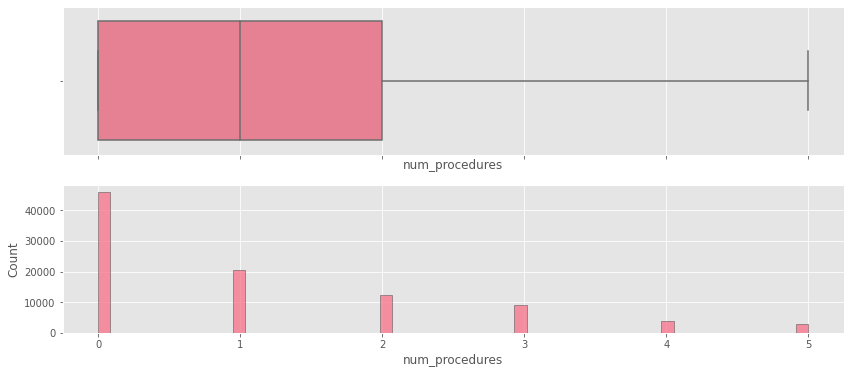

In [163]:
fig, axs = plt.subplots(2, figsize = (14,6), sharex = True)

sns.boxplot(x=df_sin_limpiar['num_procedures'], ax=axs[0]);
sns.histplot(
    df_sin_limpiar,
    x="num_procedures",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
    ax=axs[1],
);

## Nº Diagnoses

In [164]:
df_sin_limpiar['number_diagnoses'].value_counts(normalize=True)

9     0.477707
5     0.114972
8     0.104661
7     0.102668
6     0.101003
4     0.055731
3     0.029215
2     0.010691
1     0.002298
16    0.000369
10    0.000169
13    0.000148
11    0.000116
15    0.000105
12    0.000084
14    0.000063
Name: number_diagnoses, dtype: float64

In [165]:
df_sin_limpiar = remover_IQR(df_sin_limpiar, 'number_diagnoses')

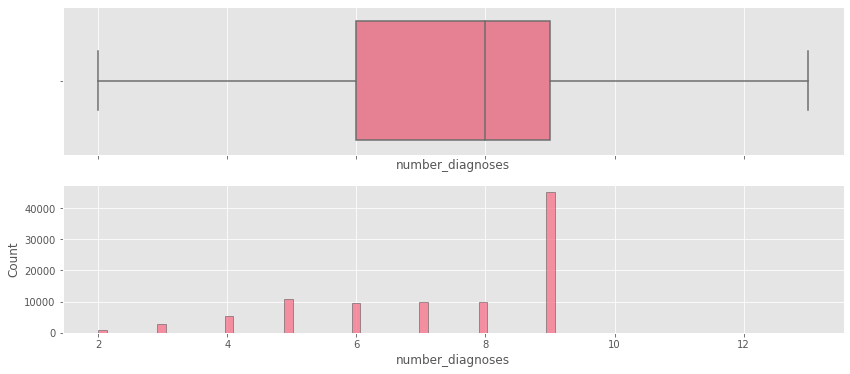

In [166]:
fig, axs = plt.subplots(2, figsize = (14,6), sharex = True)

sns.boxplot(x=df_sin_limpiar['number_diagnoses'], ax=axs[0]);
sns.histplot(
    df_sin_limpiar,
    x="number_diagnoses",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
    ax=axs[1],
);

## Insulin

In [167]:
df_sin_limpiar['insulin'].value_counts(normalize=True)

No        0.471410
Steady    0.302643
Down      0.117964
Up        0.107983
Name: insulin, dtype: float64

## Change

In [168]:
df_sin_limpiar['change'].value_counts(normalize=True)

No    0.542461
Ch    0.457539
Name: change, dtype: float64

## Diabetes Med

In [169]:
df_sin_limpiar['diabetesMed'].value_counts(normalize=True)

Yes    0.767699
No     0.232301
Name: diabetesMed, dtype: float64

## Readmitted -> target

In [170]:
df_sin_limpiar['readmitted'].value_counts(normalize=True)

NO     0.536636
>30    0.351089
<30    0.112275
Name: readmitted, dtype: float64

In [171]:
df_sin_limpiar['target'] = (df_sin_limpiar['readmitted']=='<30').astype('int')

df_sin_limpiar.drop(['readmitted'],axis=1,inplace=True)

In [172]:
df_sin_limpiar['target'].value_counts(normalize=True)

0    0.887725
1    0.112275
Name: target, dtype: float64

In [173]:
columnas_cat.append('target')

## Cambiar Tipo de Dato

In [174]:
columnas_cat.remove('readmitted')

In [175]:
for col in columnas_cat:
    df_sin_limpiar[col] = df_sin_limpiar[col].astype('category')

In [176]:
df_sin_limpiar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94580 entries, 1 to 101765
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   race                      94580 non-null  category
 1   gender                    94580 non-null  category
 2   age                       94580 non-null  category
 3   tiene_weight              94580 non-null  category
 4   admission_type_id         94580 non-null  category
 5   discharge_disposition_id  94580 non-null  category
 6   admission_source_id       94580 non-null  category
 7   payer_code                94580 non-null  category
 8   medical_specialty         94580 non-null  category
 9   num_procedures            94580 non-null  category
 10  insulin                   94580 non-null  category
 11  change                    94580 non-null  category
 12  diabetesMed               94580 non-null  category
 13  time_in_hospital          94580 non-null  int

## Encoding

In [177]:
for col in columnas_cat:
    label_encoder = LabelEncoder()
    df_sin_limpiar[col] = label_encoder.fit_transform(df_sin_limpiar[col].values)

In [178]:
df_sin_limpiar[columnas_num] -= df_sin_limpiar[columnas_num].min()
df_sin_limpiar[columnas_num] /= df_sin_limpiar[columnas_num].max()

In [179]:
col_dummmies = ['race', 'gender', 'age', 'admission_type_id', 'medical_specialty']
df_sin_limpiar.columns

Index(['race', 'gender', 'age', 'tiene_weight', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'payer_code',
       'medical_specialty', 'num_procedures', 'insulin', 'change',
       'diabetesMed', 'time_in_hospital', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'target'],
      dtype='object')

In [180]:
for col in col_dummmies:
    df_sin_limpiar = pd.get_dummies(df_sin_limpiar, columns=[col], drop_first=True)

In [181]:
columnas_box_cox

['number_outpatient', 'number_emergency']

In [182]:
encoder = PowerTransformer()
df_sin_limpiar['number_outpatient'] = encoder.fit_transform(df_sin_limpiar['number_outpatient'].values.reshape(-1, 1))

In [183]:
encoder = PowerTransformer()
df_sin_limpiar['number_emergency'] = encoder.fit_transform(df_sin_limpiar['number_emergency'].values.reshape(-1, 1))

# Modelado

In [184]:
df = df_sin_limpiar

In [185]:
df.head()

,tiene_weight,discharge_disposition_id,admission_source_id,payer_code,num_procedures,insulin,change,diabetesMed,time_in_hospital,num_medications,...,admission_type_id_7,medical_specialty_1,medical_specialty_2,medical_specialty_3,medical_specialty_4,medical_specialty_5,medical_specialty_6,medical_specialty_7,medical_specialty_8,medical_specialty_9
1,0,0,6,0,0,3,0,1,0.181818,0.2125,...,0,0,0,0,0,0,0,1,0,0
2,0,0,6,0,5,1,1,1,0.090909,0.1500,...,0,0,0,0,0,0,0,1,0,0
3,0,0,6,0,1,3,0,1,0.090909,0.1875,...,0,0,0,0,0,0,0,1,0,0
4,0,0,6,0,0,2,0,1,0.000000,0.0875,...,0,0,0,0,0,0,0,1,0,0
6,0,0,1,0,1,2,0,1,0.272727,0.2500,...,0,0,0,0,0,0,0,1,0,0


In [186]:
df.shape

(94580, 47)

In [187]:
y = df['target']
X = df.loc[:, df.columns != 'target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = SEED)

In [189]:
classifiers = []

classifiers.append(LogisticRegression(max_iter=1000, fit_intercept=True, penalty='l2'))
classifiers.append(DecisionTreeClassifier(random_state = 100, max_depth=3, min_samples_leaf=5))
classifiers.append(BernoulliNB(alpha=100))
classifiers.append(GaussianNB())
#classifiers.append(SVC())

acc = []
pre = []
rec = []
models = []

for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred= clf.predict(X_test)
    acc_i = accuracy_score(y_test, y_pred)
    pre_i = precision_score(y_test, y_pred)
    rec_i = recall_score(y_test, y_pred)
    
    models.append(str(clf))
    acc.append(acc_i)
    pre.append(pre_i)
    rec.append(rec_i)
    
    print("Accuracy de '%s': %s"%(clf, acc_i))
    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de Confusión de %s:\n\n%s"%(clf, cm))
    print(classification_report(y_test, y_pred, digits=3))
    print('\n')

Accuracy de 'LogisticRegression(max_iter=1000)': 0.8893694732795079
Matriz de Confusión de LogisticRegression(max_iter=1000):

[[27702    40]
 [ 3413    57]]
              precision    recall  f1-score   support

           0      0.890     0.999     0.941     27742
           1      0.588     0.016     0.032      3470

    accuracy                          0.889     31212
   macro avg      0.739     0.507     0.487     31212
weighted avg      0.857     0.889     0.840     31212



Accuracy de 'DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=100)': 0.8892413174420095
Matriz de Confusión de DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=100):

[[27725    17]
 [ 3440    30]]
              precision    recall  f1-score   support

           0      0.890     0.999     0.941     27742
           1      0.638     0.009     0.017      3470

    accuracy                          0.889     31212
   macro avg      0.764     0.504     0.479     31212
wei

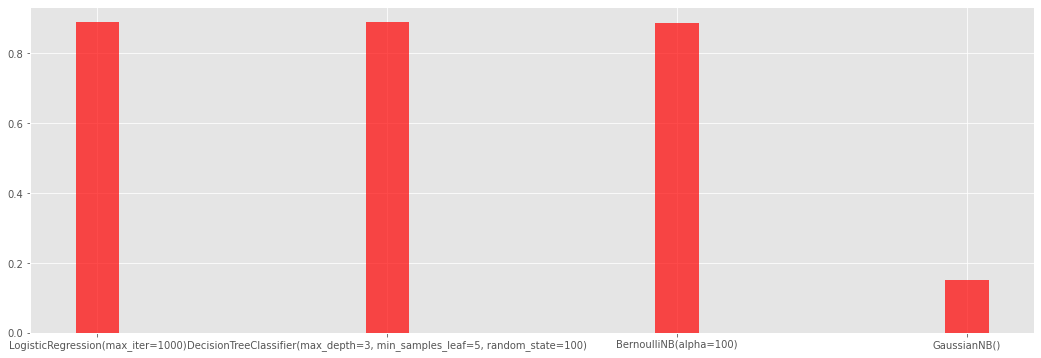

In [193]:
model = np.arange(len(models))

plt.bar(model, acc, align='center', width = 0.15, alpha=0.7, color = 'red', label= 'accuracy');
plt.xticks(model, models);

In [ ]:
plt.bar(model, acc, align='center', width = 0.15, alpha=0.7, color = 'red', label= 'accuracy');
plt.xticks(model, models);